In [75]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import scale
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xg
from sklearn.inspection import permutation_importance


# EDA

**Resort 1** is close to a large metropolitan area (approx 455,000 people). The resort's lift capacity is 9,980 riders/hour. 

The resort generously gave us four seasons' worth of daily visit totals in an excel document. The daily visits were further broken down into season pass holder visits vs day ticket visits, day vs night vists. 

A couple notes on getting the data for this particular ski area: 

* `SCHOOL_OUT` is if the public school district did not have class on a day that normally would have school (weekday). These included Winter Break, MLK Day, Presidents' Day, and Spring Break. Weekends surrounding school closures such as Thanksgiving, Presidents Day, were not counted as a school out day. I was able to source this from the local school district's website. 

* Mountain Weather Data was gathered from a NOAA weather station on the mountain where the resort is located.

* Town weather Data was gathered from the metropolitan area's airport. 

### After cleaning stats: 

**Daily Visits:**

count     484.000000

mean     2421.783058

std      1709.932584

min        48.00000

25%      1037.500000

50%      2015.500000

75%      3503.500000

max      7144.000000

In [2]:
df_1 = pd.read_csv('Data/Resort_1.csv', thousands=',')
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 567 entries, 0 to 566
Data columns (total 27 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Date                 567 non-null    object 
 1   Day of week          567 non-null    object 
 2   is_school_out        567 non-null    int64  
 3   is_holiday           567 non-null    int64  
 4   Day Tickets          567 non-null    int64  
 5   Night Ticket         534 non-null    float64
 6   Total Ticket         567 non-null    int64  
 7   SP Day               428 non-null    float64
 8   SP Night             403 non-null    float64
 9   Total SP             567 non-null    float64
 10  Total VIsits Alpine  567 non-null    float64
 11  T - AWND             567 non-null    float64
 12  T - PRCP             567 non-null    float64
 13  T - SNOW             567 non-null    float64
 14  T - SNWD             567 non-null    float64
 15  T - TAVG             567 non-null    int

In [3]:
#See if there's any duplicates: 
df_1.duplicated().value_counts()

False    567
dtype: int64

Make the `Date` column a datetime object, create day of week and month category, we'll use these variables in our models to see if they have any predictive power.

In [4]:
#Date dealings - make the 'Date' column a datetime object, create day of week and month category to do some EDA and use as variables
#make the 'Date' Column a datetime type
df_1['Date'] = pd.to_datetime(df_1['Date'])

#The day_of_week_num column created with Monday=0, Sunday=6. Weekends = 5 & 6, Friday = 4
df_1['day_of_week_num'] = df_1['Date'].dt.dayofweek

#creating Month Column
df_1['month'] = df_1['Date'].dt.month

#no need for day of week column in a string anymore
df_1.drop(['Day of week'], axis=1, inplace = True)

df_1['month'].value_counts()

3     124
1     124
12    119
2     113
4      50
11     37
Name: month, dtype: int64

In [5]:
df_1.describe()

,is_school_out,is_holiday,Day Tickets,Night Ticket,Total Ticket,SP Day,SP Night,Total SP,Total VIsits Alpine,T - AWND,...,T - WSF5,M_PRCP,M_SNWD,M_TAVG,M_TMAX,M_TMIN,M_TOBS,M_WESD,day_of_week_num,month
count,567.000000,567.000000,567.000000,534.000000,567.000000,428.000000,403.000000,567.000000,567.000000,567.000000,...,567.000000,567.000000,567.000000,567.000000,567.000000,567.000000,567.000000,567.000000,567.000000,567.000000
mean,0.165785,0.044092,385.682540,158.926966,535.359788,1331.829439,399.446650,1531.911817,2067.271605,7.486543,...,24.092945,0.136861,44.700176,30.261023,36.954145,23.684303,28.620811,13.992769,3.028219,4.862434
std,0.372216,0.205480,391.935468,162.385131,519.033824,1121.998633,376.617499,1342.187125,1797.017090,3.493179,...,8.445873,0.224944,23.450912,7.074986,7.965341,7.649856,7.730381,8.535443,1.998033,4.347793
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.120000,...,8.900000,0.000000,0.000000,5.000000,17.000000,-8.000000,2.000000,0.000000,0.000000,1.000000
25%,0.000000,0.000000,104.500000,0.000000,120.000000,549.750000,0.000000,461.000000,636.000000,4.920000,...,18.100000,0.000000,25.000000,25.000000,31.000000,18.500000,24.000000,7.000000,1.000000,2.000000
50%,0.000000,0.000000,241.000000,116.000000,371.000000,986.500000,347.000000,1212.000000,1641.000000,6.710000,...,23.000000,0.000000,47.000000,30.000000,36.000000,24.000000,29.000000,13.700000,3.000000,3.000000
75%,0.000000,0.000000,598.500000,265.250000,836.500000,2071.750000,606.000000,2348.500000,3187.500000,9.620000,...,30.000000,0.200000,60.000000,35.000000,42.000000,29.000000,34.000000,20.600000,5.000000,11.000000
max,1.000000,1.000000,1884.000000,790.000000,2277.000000,4792.000000,1668.000000,5461.000000,7144.000000,20.800000,...,61.100000,1.100000,95.000000,50.000000,61.000000,42.000000,49.000000,33.000000,6.000000,12.000000


In [6]:
df_1.rename(columns = {'Total VIsits Alpine':'TOTAL_VISITS'}, inplace = True)

In [7]:
df_1.isnull().sum()

Date                 0
is_school_out        0
is_holiday           0
Day Tickets          0
Night Ticket        33
Total Ticket         0
SP Day             139
SP Night           164
Total SP             0
TOTAL_VISITS         0
T - AWND             0
T - PRCP             0
T - SNOW             0
T - SNWD             0
T - TAVG             0
T - TMAX             0
T - TMIN             0
T - WSF2             0
T - WSF5             0
M_PRCP               0
M_SNWD               0
M_TAVG               0
M_TMAX               0
M_TMIN               0
M_TOBS               0
M_WESD               0
day_of_week_num      0
month                0
dtype: int64

# Correlation Matrix 
Let's start exploring correlation, taking out `TOTAL_VISITS` (our target), SP, Day and Night related ticket totals to see if any of our variables are highly correlated. Also taking out `Date` as the specific date is not a predictor. 


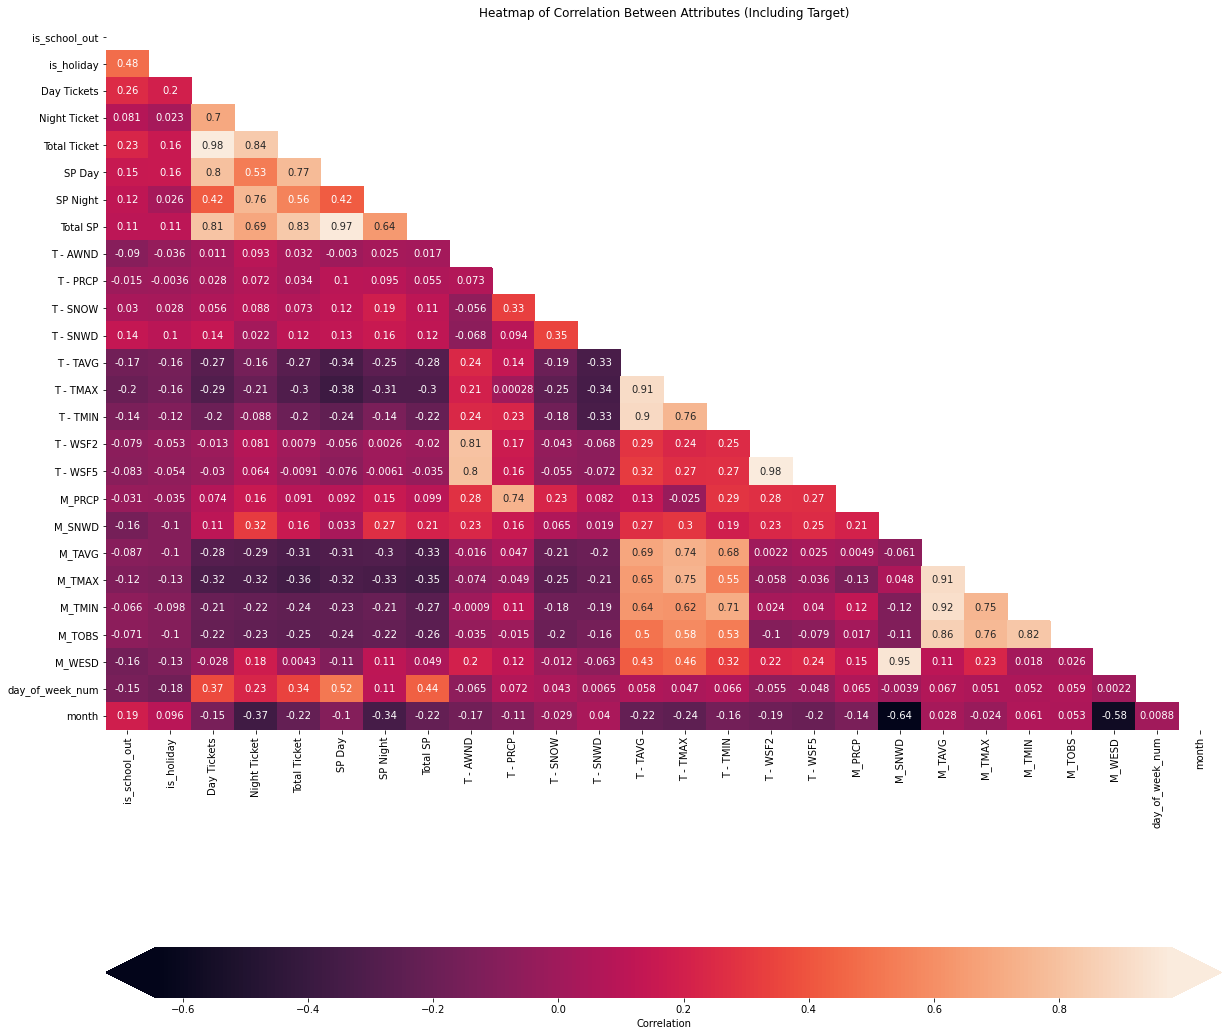

In [8]:

#removing predictor (visit) and date columns for correlation testing
df_1_corr = df_1.drop(columns=['Date', 'TOTAL_VISITS'])

# Create a df with the target as the first column,
# then compute the correlation matrix
heatmap_data = df_1_corr
corr = heatmap_data.corr()

# Set up figure and axes
fig, ax = plt.subplots(figsize=(20, 20))

# Plot a heatmap of the correlation matrix, with both
# numbers and colors indicating the correlations
sns.heatmap(data=corr, mask=np.triu(np.ones_like(corr, dtype=bool)), ax=ax, annot=True, 
            cbar_kws={"label": "Correlation", "orientation": "horizontal", "pad": .2, "extend": "both"})

ax.set_title("Heatmap of Correlation Between Attributes (Including Target)");

In [9]:
#identifying the highest correlated variables

df = df_1_corr.corr().abs().stack().reset_index().sort_values(0, ascending=False)

df['pairs'] = list(zip(df.level_0, df.level_1))

df.set_index(['pairs'], inplace = True)

df.drop(columns=['level_1', 'level_0'], inplace = True)

# cc for correlation coefficient
df.columns = ['cc']

df.drop_duplicates(inplace=True)

df[(df.cc>.75) & (df.cc<1)]


,cc
pairs,
"(T - WSF5, T - WSF2)",0.978815
"(Day Tickets, Total Ticket)",0.975263
"(SP Day, Total SP)",0.967140
"(M_WESD, M_SNWD)",0.953119
"(M_TMIN, M_TAVG)",0.924962
"(M_TMAX, M_TAVG)",0.912155
"(T - TAVG, T - TMAX)",0.911270
"(T - TMIN, T - TAVG)",0.902078
"(M_TOBS, M_TAVG)",0.861747


### Multicollinairity decision

Based on the information above it makes sense to drop some data, especially the weather data: 

**Weather:** 

- `T_WSF5` (fastest 5 min wind speed in the metropolotan(town) area)
- `M_WESD` (water equivalent snow on the ground on the mountain)
- `M_TMIN` + `T_TMIN` (temperature min on the mountain and in town)
- `M_TMAX` + `T_TMAX` (temperature max on the mountain and in town)
- `T_TOBS` + `M_TOBS` (temperature at time of observation on mtn and in town)
- `T_WSF2` (fastest 2 min wind speend, keeping the average wind speed for town)

**Ticketing:**

To keep things simple I think for now I am going to remove the ticketing and visit informatoin that breaks down season pass vs ticket and night vs day ticketing. I may want to use these as a prediction if there's time or the business need becomes obvious. Unfortunately I don't have pre-sale data to work with. 

- `SP Night`
- `SP Day`
- `Day Tickets`
- `Night Ticket`
- `Total Tickets`
- `Total SP`

In [10]:
df_1_preprocessed = df_1.drop(columns=['T - WSF5', 'M_WESD', 'M_TMIN', 'T - TMIN', 'M_TMAX', 'T - TMAX', 'M_TOBS', 'T - WSF2', 'SP Night', 'SP Day', 'Day Tickets', 'Night Ticket', 'Total Ticket', 'Total SP'])
df_1_preprocessed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 567 entries, 0 to 566
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Date             567 non-null    datetime64[ns]
 1   is_school_out    567 non-null    int64         
 2   is_holiday       567 non-null    int64         
 3   TOTAL_VISITS     567 non-null    float64       
 4   T - AWND         567 non-null    float64       
 5   T - PRCP         567 non-null    float64       
 6   T - SNOW         567 non-null    float64       
 7   T - SNWD         567 non-null    float64       
 8   T - TAVG         567 non-null    int64         
 9   M_PRCP           567 non-null    float64       
 10  M_SNWD           567 non-null    int64         
 11  M_TAVG           567 non-null    int64         
 12  day_of_week_num  567 non-null    int64         
 13  month            567 non-null    int64         
dtypes: datetime64[ns](1), float64(6), int64(7)

## 0 visit days
Taking a look at rows with 0 visits (these are the days the resort is closed)

In [11]:
df_1_preprocessed[df_1_preprocessed.TOTAL_VISITS == 0]

,Date,is_school_out,is_holiday,TOTAL_VISITS,T - AWND,T - PRCP,T - SNOW,T - SNWD,T - TAVG,M_PRCP,M_SNWD,M_TAVG,day_of_week_num,month
0,2017-11-21,1,0,0.0,7.61,0.05,0.0,0.0,49,0.2,7,43,1,11
1,2017-11-22,1,0,0.0,4.47,0.01,0.0,0.0,55,0.1,6,47,2,11
2,2017-11-23,1,1,0.0,7.16,0.01,0.0,0.0,53,0.1,4,49,3,11
3,2017-11-24,1,0,0.0,6.49,0.26,0.0,0.0,53,0.1,4,35,4,11
4,2017-11-25,0,0,0.0,7.38,0.00,0.0,0.0,43,0.2,3,41,5,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
560,2021-04-12,0,0,0.0,3.80,0.00,0.0,0.0,41,0.0,45,32,0,4
561,2021-04-13,0,0,0.0,6.71,0.00,0.0,0.0,47,0.0,43,36,1,4
562,2021-04-14,0,0,0.0,6.93,0.00,0.0,0.0,48,0.0,42,35,2,4
563,2021-04-15,0,0,0.0,8.28,0.00,0.0,0.0,50,0.0,41,38,3,4


In [12]:
#dropping the 0 visit days: 
df_1_preprocessed = df_1_preprocessed[df_1_preprocessed.TOTAL_VISITS != 0]
df_1_preprocessed['TOTAL_VISITS'].value_counts()

2203.0    3
978.0     3
715.0     2
1355.0    2
879.0     2
         ..
883.0     1
7144.0    1
5748.0    1
895.0     1
432.0     1
Name: TOTAL_VISITS, Length: 464, dtype: int64

In [13]:
df_1_preprocessed['TOTAL_VISITS'].describe()

count     484.000000
mean     2421.783058
std      1709.932584
min        48.000000
25%      1037.500000
50%      2015.500000
75%      3503.500000
max      7144.000000
Name: TOTAL_VISITS, dtype: float64

## Indexing with Date

In [14]:
#df_1_preprocessed.reset_index(inplace=True)
df_1_preprocessed.set_index('Date', inplace=True)
df_1_preprocessed.head(2)

,is_school_out,is_holiday,TOTAL_VISITS,T - AWND,T - PRCP,T - SNOW,T - SNWD,T - TAVG,M_PRCP,M_SNWD,M_TAVG,day_of_week_num,month
Date,,,,,,,,,,,,,
2017-12-21,0,0,432.0,10.07,0.00,0.0,0.0,29,0.0,15,21,3,12
2017-12-22,1,0,48.0,4.47,0.14,4.0,0.0,32,0.3,19,24,4,12


# Visualizations

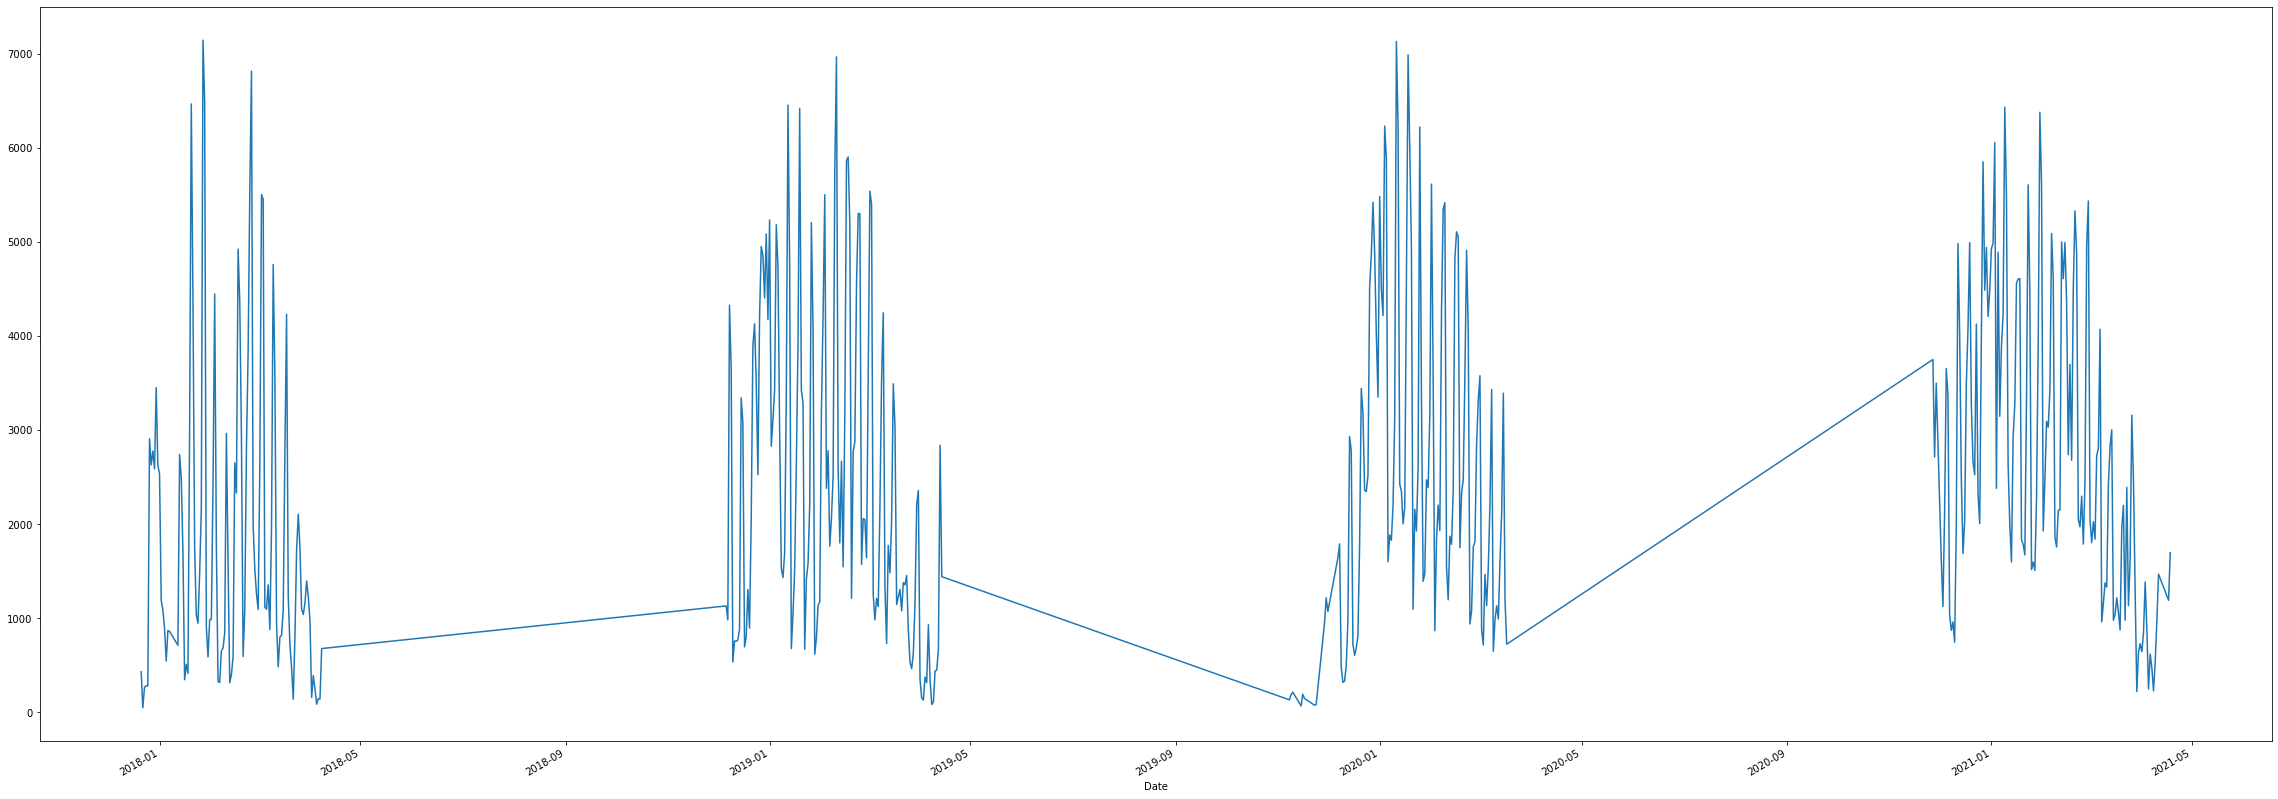

In [15]:
df_1_preprocessed['TOTAL_VISITS'].plot(figsize = (40, 15));

month
1     2482.5
2     2602.0
3     1221.5
4      247.5
11       0.0
12    1687.0
Name: TOTAL_VISITS, dtype: float64
month
1     2571.0
2     2602.0
3     1337.0
4      449.0
11     193.0
12    2525.0
Name: TOTAL_VISITS, dtype: float64


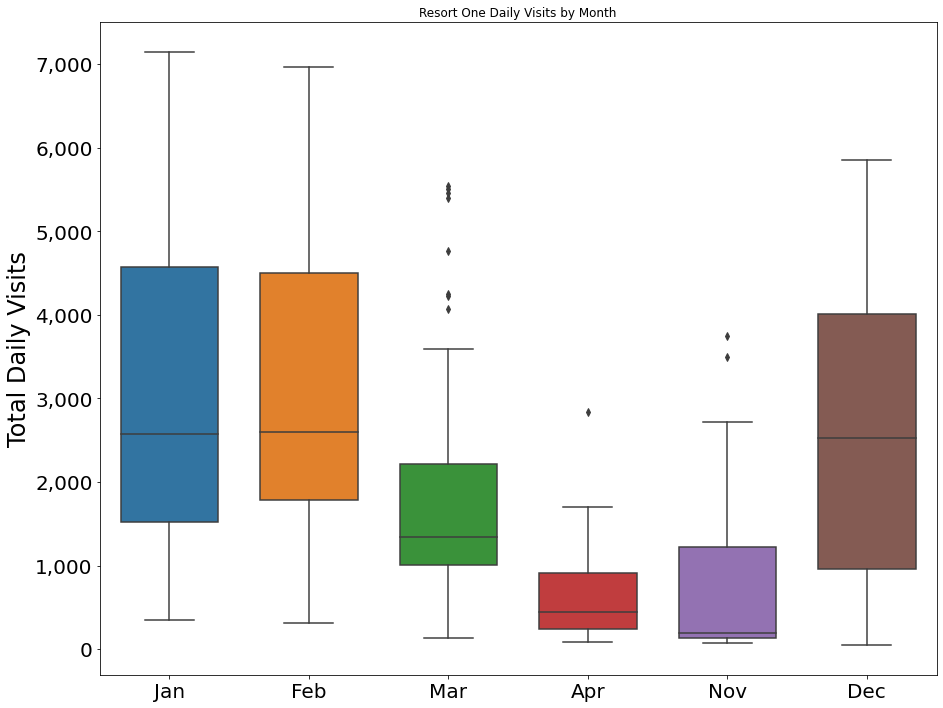

In [16]:
medians = df_1.groupby(['month'])['TOTAL_VISITS'].median()
print(medians)

import matplotlib as mpl

fig, ax = plt.subplots(figsize=(15, 12))
sns.boxplot(x='month', y='TOTAL_VISITS', data=df_1_preprocessed, width=.7)

medians = df_1_preprocessed.groupby(['month'])['TOTAL_VISITS'].median()
print(medians)

ax.set_xlabel("")

ax.set_ylabel("Total Daily Visits", fontsize=24)

ax.set_title("Resort One Daily Visits by Month")

plt.yticks(fontsize=20)

plt.xticks([0, 1, 2, 3, 4, 5], ['Jan', 'Feb', 'Mar', 'Apr', 'Nov', 'Dec'], fontsize=20)

ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

plt.savefig('Visuals/resort2visits.png', dpi=300);

Let's look at the relationship between visitors and Precipitation on the Mountain: 

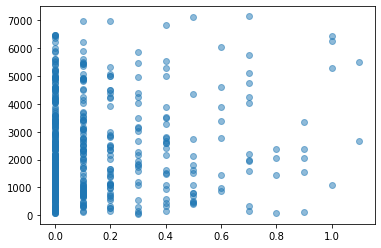

In [17]:
fig, ax = plt.subplots()

ax.scatter(df_1_preprocessed['M_PRCP'], df_1_preprocessed["TOTAL_VISITS"], alpha=0.5)

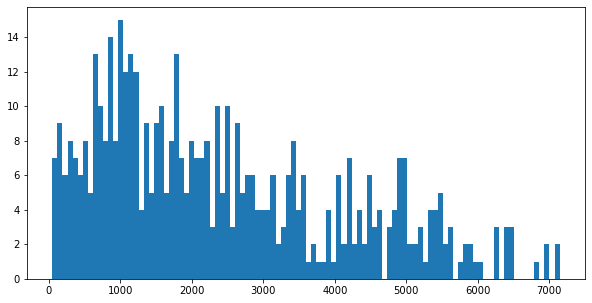

In [18]:
#visualization of target - Visits
fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(df_1_preprocessed['TOTAL_VISITS'], bins=100);

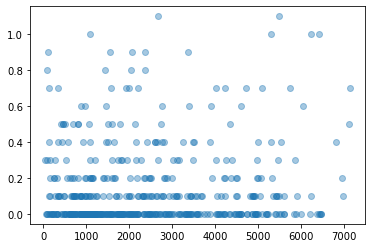

In [20]:
#Relationship between mountain precipitation and visitation
plt.scatter(y=df_1_preprocessed['M_PRCP'], x=df_1_preprocessed['TOTAL_VISITS'], alpha=.4)
plt.savefig('Visuals/resort1precip.png', dpi=300);

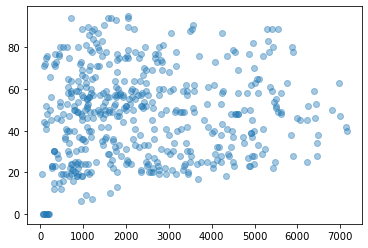

In [21]:
#relationship between snowdepth and visitation
plt.scatter(y=df_1_preprocessed['M_SNWD'], x=df_1_preprocessed['TOTAL_VISITS'], alpha=.4)
plt.savefig('Visuals/resort1msnowdepth.png', dpi=300);

At first glance, calendar events seem to have more impact on visitation: 

is_holiday
0    2373.318872
1    3393.173913
Name: TOTAL_VISITS, dtype: float64
is_school_out
0    2287.069479
1    3092.024691
Name: TOTAL_VISITS, dtype: float64


<AxesSubplot:xlabel='M_PRCP', ylabel='TOTAL_VISITS'>

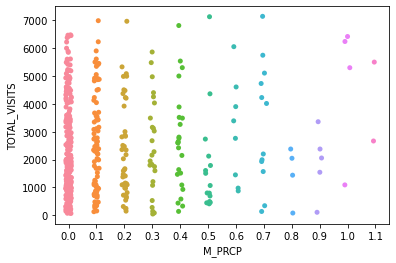

In [22]:
Holiday_averages=df_1_preprocessed.groupby(df_1_preprocessed['is_holiday'])['TOTAL_VISITS'].mean()
print(Holiday_averages)

Schoolout_averages=df_1_preprocessed.groupby(df_1_preprocessed['is_school_out'])['TOTAL_VISITS'].mean()
print(Schoolout_averages)

fig, ax = plt.subplots()
sns.stripplot(x='M_PRCP', y='TOTAL_VISITS', data=df_1_preprocessed)

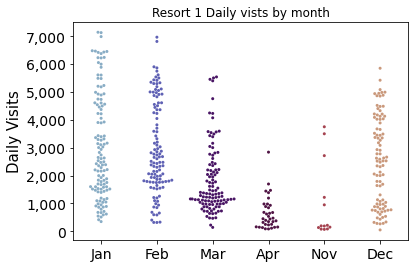

In [23]:
fig, ax = plt.subplots()
sns.swarmplot(x='month', y='TOTAL_VISITS', data=df_1_preprocessed, size=3, palette='twilight', edgecolor='none')

ax.set_xlabel("")
ax.set_title("Resort 1 Daily vists by month")
ax.set_ylabel("Daily Visits", fontsize=15)
plt.yticks(fontsize=14)
plt.xticks([0, 1, 2, 3, 4, 5], ['Jan', 'Feb', 'Mar', 'Apr', 'Nov', 'Dec'], fontsize=14)

ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
plt.savefig('Visuals/resort1swarmplotmonth.png', dpi=300);

### Saving Cleaned Resort 3 Data to CSV for reference: 

In [24]:
df_1_preprocessed.to_csv("Data/DF_1_clean.csv")

# First Simple Model
Linear Regression

In [25]:
#Split into test and train X and Y
X = df_1_preprocessed.drop(columns=['TOTAL_VISITS'])
y = df_1_preprocessed['TOTAL_VISITS']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
#visualizing our X
X.head()

,is_school_out,is_holiday,T - AWND,T - PRCP,T - SNOW,T - SNWD,T - TAVG,M_PRCP,M_SNWD,M_TAVG,day_of_week_num,month
Date,,,,,,,,,,,,
2017-12-21,0,0,10.07,0.00,0.0,0.0,29,0.0,15,21,3,12
2017-12-22,1,0,4.47,0.14,4.0,0.0,32,0.3,19,24,4,12
2017-12-23,1,0,6.93,0.14,2.1,5.1,32,0.0,23,18,5,12
2017-12-24,1,1,4.70,0.13,1.8,3.9,17,0.3,23,19,6,12
2017-12-25,1,1,3.36,0.09,1.0,5.9,22,0.1,22,26,0,12


In [36]:
# creating categorical lists for upcoming Transformer: 
cat = ['is_school_out', 'is_holiday', 'day_of_week_num', 'month']
non_cat = ['T - AWND', 'T - PRCP', 'T - SNOW', 'T - SNWD', 'T - TAVG', 'M_PRCP', 'M_SNWD', 'M_TAVG']

# Baseline Linear Regression model with OHE and Standard Scaler in a pipeline

In [37]:
Transformer = ColumnTransformer([
	('ohe', OneHotEncoder(), cat),
	('scaler', StandardScaler(), non_cat),
	], remainder ='passthrough')

#setting up the pipe and training the model: 

LRPipe = Pipeline([('trans', Transformer),
                ('linreg', LinearRegression())])

LRPipe.fit(X_train, y_train)

#cross validation and scoring
cv_LR = cross_validate(LRPipe, X_train, y_train, return_train_score=True, cv=5)
cv_score_LR = cross_val_score(LRPipe, X_train, y_train, cv = 5)

print(f'Cross Validation Scores, Linear Regression: {cv_LR}')

print(f'mean CV Score, Linear Regression, Resort 3: {cv_score_LR.mean()}')

Cross Validation Scores, Linear Regression: {'fit_time': array([0.02007294, 0.01709294, 0.02621102, 0.02382612, 0.0328722 ]), 'score_time': array([0.00946045, 0.01307106, 0.01764679, 0.01177788, 0.01230693]), 'test_score': array([0.47984437, 0.53637444, 0.73232436, 0.66131302, 0.48757651]), 'train_score': array([0.68906124, 0.67728235, 0.63319602, 0.64723468, 0.68273521])}
mean CV Score, Linear Regression, Resort 3: 0.5794865402447538


With Encoding and scaling, the Basic Linear Regression CV score is 0.576

There is definitly some room for improvement, but we're doing OK so far.


## Tree Regressor

In [39]:
Transformer = ColumnTransformer([
	('ohe', OneHotEncoder(), cat),
	# ('scaler', StandardScaler(), non_cat), #no need to scale on Trees
	], remainder ='passthrough')

#Pipeline second Step: treeregressor
dt_clf2 = DecisionTreeRegressor(random_state = 42)

#pipeline
pipeline_dt = Pipeline([('transformer', Transformer),
						('dtr', dt_clf2)])

#set up grid search paramater grid
dt_param_grid = {
    'dtr__min_samples_split': [2, 4, 6, 8],
    'dtr__max_depth': [None, 2, 3, 4, 5, 6]
}

#set up gridsearch:
gridsearch_dt = GridSearchCV(estimator=pipeline_dt,
						  param_grid=dt_param_grid,
						  cv=5)

#fit gridsearch
gridsearch_dt.fit(X_train, y_train)

print("Best Parameter Combination for Tree Regressor Found During Grid Search:")
print(gridsearch_dt.best_params_)

Best Parameter Combination for Tree Regressor Found During Grid Search:
{'dtr__max_depth': 5, 'dtr__min_samples_split': 4}


In [42]:
Transformer = ColumnTransformer([
	('ohe', OneHotEncoder(), cat),
	# ('scaler', StandardScaler(), non_cat), #no need to scale on Trees
	], remainder ='passthrough')

#Pipeline second Step: treeregressor
dt_clf3 = DecisionTreeRegressor(max_depth=5, min_samples_split=4, random_state = 42)

#pipeline
pipeline_dt_best = Pipeline([('transformer', Transformer),
						('dtr', dt_clf3)])


pipeline_dt_best.fit(X_train, y_train)

cv = cross_validate(pipeline_dt_best, X_train, y_train, return_train_score=True, cv=5)
cv_score = cross_val_score(pipeline_dt_best, X_train, y_train, cv = 5)
print(f'Cross Validation Scores bDecision treeest Decision Tree Regressor: {cv}')

print(f'mean CV Score: {cv_score.mean()}')

Cross Validation Scores best Decision Tree Regressor: {'fit_time': array([0.01480794, 0.01194692, 0.01098418, 0.01232386, 0.01190805]), 'score_time': array([0.01867414, 0.015836  , 0.00433683, 0.00528598, 0.00668383]), 'test_score': array([0.44124527, 0.54965897, 0.45015904, 0.688071  , 0.41617338]), 'train_score': array([0.73431034, 0.76736684, 0.7726827 , 0.7539595 , 0.7848853 ])}
mean CV Score: 0.509061532768853


Decision Tree performed worse than Linear Regression at a mean CV score of 0.509.

## Trying Random Forests:

In [45]:


Transformer = ColumnTransformer([
	('ohe', OneHotEncoder(), cat),
	# ('scaler', StandardScaler(), non_cat), #no need to scale on Trees
	], remainder ='passthrough')

#Pipeline second Step: treeregressor
rfr = RandomForestRegressor(random_state = 42)

#pipeline
pipeline_rfr = Pipeline([('transformer', Transformer),
						('dtr', rfr)])

#set up grid search paramater grid
rfr_param_grid = {
    'dtr__n_estimators': [2, 4, 6, 8, 10, 12, 14, 16],
    'dtr__max_depth': [None, 2, 3, 4, 5, 6, 8, 10],
	'dtr__max_features': ['auto', 'sqrt', 'log2'],
	'dtr__criterion': ['mse', 'mae']
}

#set up gridsearch:
gridsearch_rfr = GridSearchCV(estimator=pipeline_rfr,
						  param_grid=rfr_param_grid,
						  cv=5)

#fit gridsearch
gridsearch_rfr.fit(X_train, y_train)

print("Best Parameter Combination Found During Grid Search:")
print(gridsearch_rfr.best_params_)


Best Parameter Combination Found During Grid Search:
{'dtr__criterion': 'mse', 'dtr__max_depth': None, 'dtr__max_features': 'sqrt', 'dtr__n_estimators': 10}


In [46]:
#modeling with best paramaters found in Grid Search: 
Transformer = ColumnTransformer([
	('ohe', OneHotEncoder(), cat),
	# ('scaler', StandardScaler(), non_cat), #no need to scale on Trees
	], remainder ='passthrough')

#Pipeline second Step: treeregressor
rfr_best = RandomForestRegressor(criterion = 'mse', max_depth = None, max_features = 'sqrt', n_estimators = 10, random_state = 42)

#pipeline
pipeline_rfr_best = Pipeline([('transformer', Transformer),
						('dtr', rfr_best)])


pipeline_rfr_best.fit(X_train, y_train)

cv = cross_validate(pipeline_rfr_best, X_train, y_train, return_train_score=True, cv=5)
cv_score = cross_val_score(pipeline_rfr_best, X_train, y_train, cv = 5)
print(f'Cross Validation Scores best Random Forest Regressor: {cv}')

print(f'mean CV Score: {cv_score.mean()}')


Cross Validation Scores best Random Forest Regressor: {'fit_time': array([0.03084493, 0.03318429, 0.02400112, 0.02225018, 0.02256608]), 'score_time': array([0.00607085, 0.00591969, 0.00492382, 0.00512409, 0.0069468 ]), 'test_score': array([0.55986679, 0.67336618, 0.74058046, 0.6732444 , 0.54516542]), 'train_score': array([0.92655425, 0.91821211, 0.9111    , 0.90889369, 0.91310719])}
mean CV Score: 0.6384446490641958


Good results with Random Forest Regressor! CV score of .6638, which is an improvement on Linear Regression

Gradient Boosting: 

In [47]:
Transformer = ColumnTransformer([
	('ohe', OneHotEncoder(), cat),
	# ('scaler', StandardScaler(), non_cat), #no need to scale on Trees
	], remainder ='passthrough')

GBR = GradientBoostingRegressor(random_state = 42)

pipeline_gbr = Pipeline([('transformer', Transformer),
						('gbr', GBR)])

#set up grid search paramater grid
gbr_param_grid = {
    'gbr__n_estimators': [50, 100, 200, 300],
    'gbr__criterion': ['friedman_mse', 'mse', 'mae'],
	'gbr__min_samples_split': [2, 3, 4, 5]

}

#set up gridsearch:
gridsearch_gbr = GridSearchCV(estimator=pipeline_gbr,
						  param_grid=gbr_param_grid,
						  cv=5)

#fit gridsearch
gridsearch_gbr.fit(X_train, y_train)

print("Best Parameter Combination Found During GBR Grid Search:")
print(gridsearch_gbr.best_params_)


Best Parameter Combination Found During Grid Search:
{'gbr__criterion': 'mse', 'gbr__min_samples_split': 5, 'gbr__n_estimators': 200}


In [48]:
Transformer = ColumnTransformer([
	('ohe', OneHotEncoder(), cat),
	# ('scaler', StandardScaler(), non_cat), #no need to scale on Trees
	], remainder ='passthrough')

GBR_best = GradientBoostingRegressor(criterion='mse', n_estimators=200, min_samples_split= 5, random_state = 42)

#pipeline
pipeline_gbr_best = Pipeline([('transformer', Transformer),
						('gbr', GBR_best)])

pipeline_gbr_best.fit(X_train, y_train)


cv = cross_validate(pipeline_gbr_best, X_train, y_train, return_train_score=True, cv=5)
cv_score = cross_val_score(pipeline_gbr_best, X_train, y_train, cv = 5)
print(f'Cross Validation Score Gradient Boosting Model: {cv}')

print(f'mean CV Score: {cv_score.mean()}')

Cross Validation Score Gradient Boosting Model: {'fit_time': array([0.20259595, 0.22575426, 0.14844108, 0.13436389, 0.12759018]), 'score_time': array([0.00437403, 0.0070889 , 0.00395775, 0.00511885, 0.00415182]), 'test_score': array([0.62728481, 0.68505887, 0.6747616 , 0.7939104 , 0.6750317 ]), 'train_score': array([0.96385551, 0.96685321, 0.96533828, 0.95868339, 0.96596248])}
mean CV Score: 0.6912094773793598


So far Gradient Booster Model is performing the best with a mean CV score of .691

## X Boost

Let's see if we can improve our scores any

In [51]:
Transformer = ColumnTransformer([
	('ohe', OneHotEncoder(), cat),
	('scaler', StandardScaler(), non_cat),
	], remainder ='passthrough')

xgb_r = xg.XGBRegressor(seed = 123)

#pipeline
xboostPipe = Pipeline([('transformer', Transformer),
						('xgb_r', xgb_r)])

# objective ='reg:squarederror', n_estimators = 10, 
boost_param_grid = {
    'xgb_r__eta': [.2, .3, .4, .5, .6, .7, .8],
	'xgb_r__max_depth': [3, 4, 5, 6, 7, 8, 9, 10]
}

gridsearch_boost = GridSearchCV(estimator=xboostPipe,
						  param_grid=boost_param_grid,
						  cv=5)

#fit gridsearch
gridsearch_boost.fit(X_train, y_train)

print("Best Parameter Combination Found During XBoost Grid Search:")
print(gridsearch_boost.best_params_)

Best Parameter Combination Found During Grid Search:
{'xgb_r__eta': 0.2, 'xgb_r__max_depth': 3}


In [52]:
Transformer = ColumnTransformer([
	('ohe', OneHotEncoder(), cat),
	('scaler', StandardScaler(), non_cat),
	], remainder ='passthrough')

#Pipeline second Step: 
xgb_r_best = xg.XGBRegressor(eta = 0.2, max_depth = 3, seed = 123)

xboost_pipe_best = Pipeline([('transformer', Transformer),
						('xgb_r_2', xgb_r_best)])

xboost_pipe_best.fit(X_train, y_train)

cv = cross_validate(xboost_pipe_best, X_train, y_train, return_train_score=True, cv=5)
cv_score = cross_val_score(xboost_pipe_best, X_train, y_train, cv = 5)
print(f'Cross Validation Scores X Boost: {cv}')

print(f'mean CV Score X Boost: {cv_score.mean()}')

Cross Validation Scores X Boost: {'fit_time': array([0.31702995, 0.12100315, 0.80777407, 0.10298109, 0.11385322]), 'score_time': array([0.01025081, 0.01284695, 0.00932789, 0.01162386, 0.01115489]), 'test_score': array([0.63686313, 0.70759651, 0.71270877, 0.7883116 , 0.6599786 ]), 'train_score': array([0.95631625, 0.96415222, 0.96199409, 0.95670808, 0.96122295])}
mean CV Score X Boost: 0.701091719734643


X boost for resort 1 is preforming slightly better than Gradient Booster Regressor at CV score of .701

# Evaulation

Evaluating X Boost model on our test data: 

In [53]:
#boost Test Score
xboost_pipe_best.score(X_test, y_test)

0.7818851261431787

XBoost gets a test CV score of .782, this means we can account for 78% of the variance in the Resort 1 data with our Gradient Booster Regressor model. 

In [71]:
y_pred_xboost = xboost_pipe_best.predict(X_test)

df = pd.DataFrame({'Real Visits Resort 1':y_test, 'Predicted XBoost Visits':y_pred_xboost, 
                    'Difference': abs(y_test - y_pred_xboost)})
print('Mean Difference, predicted - actual')
print(df['Difference'].mean())
df.head()

Mean Difference, predicted - actual
682.2084655761719


,Real Visits Resort 1,Predicted XBoost Visits,Difference
Date,,,
2021-02-07,4612.0,4164.014648,447.985352
2021-04-04,887.0,1871.096924,984.096924
2019-02-20,2769.0,3016.289795,247.289795
2021-03-07,4072.0,3139.466309,932.533691
2020-01-27,1393.0,2205.445312,812.445312


In [74]:
ohe = xboost_pipe_best.named_steps["transformer"].transformers_[0][1].get_feature_names()
numbers = non_cat

columns = [*ohe, *numbers]

for name, importance in zip(columns, xboost_pipe_best['xgb_r_2'].feature_importances_):
    print(name, importance)

x0_0 0.10317365
x0_1 0.0
x1_0 0.023376193
x1_1 0.0
x2_0 0.020765841
x2_1 0.057336442
x2_2 0.0019764253
x2_3 0.0025452178
x2_4 0.0350706
x2_5 0.13947353
x2_6 0.1654163
x3_1 0.0370424
x3_2 0.037307676
x3_3 0.045449104
x3_4 0.040754948
x3_11 0.08848914
x3_12 0.012864601
T - AWND 0.010084906
T - PRCP 0.0097507825
T - SNOW 0.01947744
T - SNWD 0.014582939
T - TAVG 0.059271418
M_PRCP 0.0070099
M_SNWD 0.050687484
M_TAVG 0.018093089


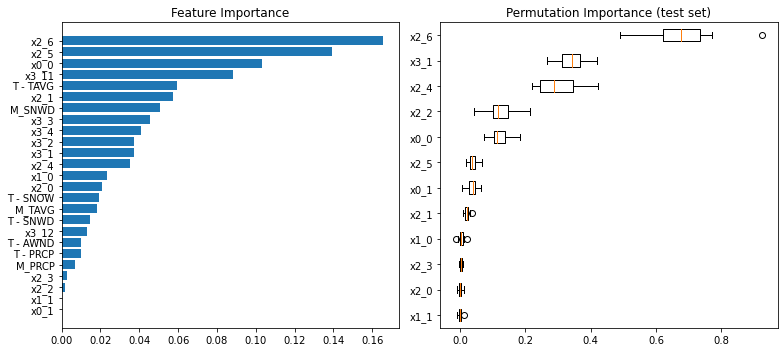

In [79]:
feature_importance = xboost_pipe_best['xgb_r_2'].feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0])
fig = plt.figure(figsize=(11, 5))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(columns)[sorted_idx])
plt.title("Feature Importance")

result = permutation_importance(
    xboost_pipe_best, X_test, y_test, n_repeats=19, random_state=42, n_jobs=2
)
result
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(columns)[sorted_idx],
)
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

# Discussion: 